# Heterokaryon Peaks Comparison

Comparing peaks in early stages of sendai reprogramming with heterokaryon reprogramming.

In [1]:
library(DESeq2)
library(ggplot2)
library(ggrepel)
library(reshape2)
library(parallel)

Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colMeans,
    colnames, colSums, dirname, do.call, duplicated, eval, evalq,
    Filter, Find, get, grep, grepl, intersect, is.unsorted, lapply,
    lengths, Map, mapply, match, mget, order, paste, pmax, pmax.int,
    pmin, pmin.int, Position, rank, rbind, Reduce, rowMeans, rownames,
    rowSums, sapply, setdiff, sort, table, tapply, union, unique,
    unsplit, which, which.max

In [2]:
cts <- read.csv("./data/scATAC.het.counts.txt",sep="\t")
rownames(cts)=paste(cts$chr,cts$start,cts$end,sep='\t')
cts$chrom = NULL
cts$start = NULL
cts$end = NULL
head(cts, 2)
dim(cts)

,D0,D2,iPSC,batch1.nodox.MRC5,batch1.nodox.CC,batch1.nodox.3hr,batch1.nodox.16hr,batch1.nodox.48hr,batch2.dn.MRC5,batch2.dn.CC,batch2.dn.3hr,batch2.dn.16hr,batch2.dn.48hr
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
chr1 181340 181540,32,31,23,4,0,0,0,6,16,7,15,9,7
chr1 183174 183374,2,2,0,0,0,0,0,2,5,7,6,2,2


[1] 521333     13

In [5]:
# remove batch2 for now
# cts = cts[, !grepl("batch2", colnames(cts))]

# cts = cts[, c("D0", "batch1.nodox.CC", "D2", "batch1.nodox.16hr", "iPSC")]
cts = cts[, c("D0", "batch1.nodox.CC", "D2", "batch1.nodox.16hr", "iPSC")]

In [6]:
cts = cts[rowSums(cts)>10, ] # trying to compensate for het samples not having enough reads
dim(cts)

[1] 520883      5

In [9]:
# divide by width
cts = 200*(cts/width(GRanges(sub("\t", "-", sub("\t", ":", rownames(cts))))))

In [10]:
norm_cts = t(t(cts)/estimateSizeFactorsForMatrix(cts[rowSums(cts<50)==0, ]))
# norm_cts = t(t(cts)/estimateSizeFactorsForMatrix(cts))

In [11]:
log_norm_cts = log2(1+norm_cts)

In [14]:
quantile_normalisation <- function(df){
  df_rank <- apply(df,2,rank,ties.method="random")
  df_sorted <- data.frame(apply(df, 2, sort))
  df_mean <- apply(df_sorted, 1, mean)
    
  index_to_mean <- function(my_index, my_mean){
    return(my_mean[my_index])
  }
   
  df_final <- apply(df_rank, 2, index_to_mean, my_mean=df_mean)
  rownames(df_final) <- rownames(df)
  df_final
}

In [15]:
qn_cts = quantile_normalisation(log_norm_cts)

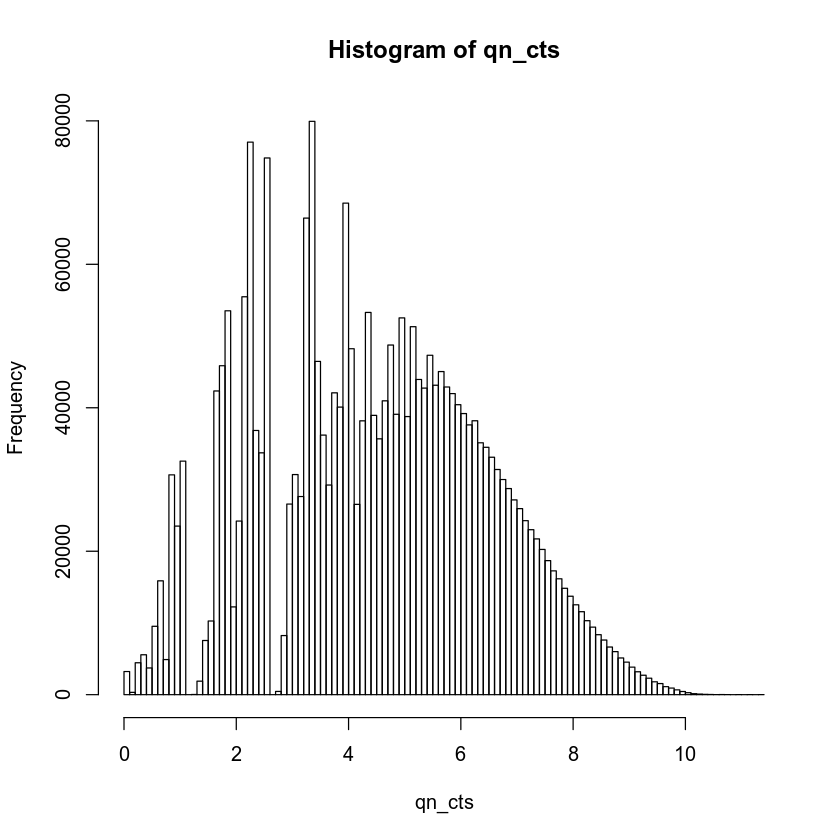

In [16]:
hist(qn_cts, breaks = 100)

In [17]:
library(RColorBrewer)

In [18]:
qual_col_pals = brewer.pal.info[brewer.pal.info$category == 'qual',]
col_vector = unlist(mapply(brewer.pal, qual_col_pals$maxcolors, rownames(qual_col_pals)))

In [20]:
pca = prcomp(t(qn_cts),center=TRUE,scale=FALSE)
pcs=data.frame(pca$x)
pcs$ID=rownames(pcs)
pcs$clust_num = colnames(log_norm_cts)
var_explained=round(100*pca$sdev^2/sum(pca$sdev^2),2)
print(var_explained)

[1] 56.71 23.04 11.84  8.41  0.00


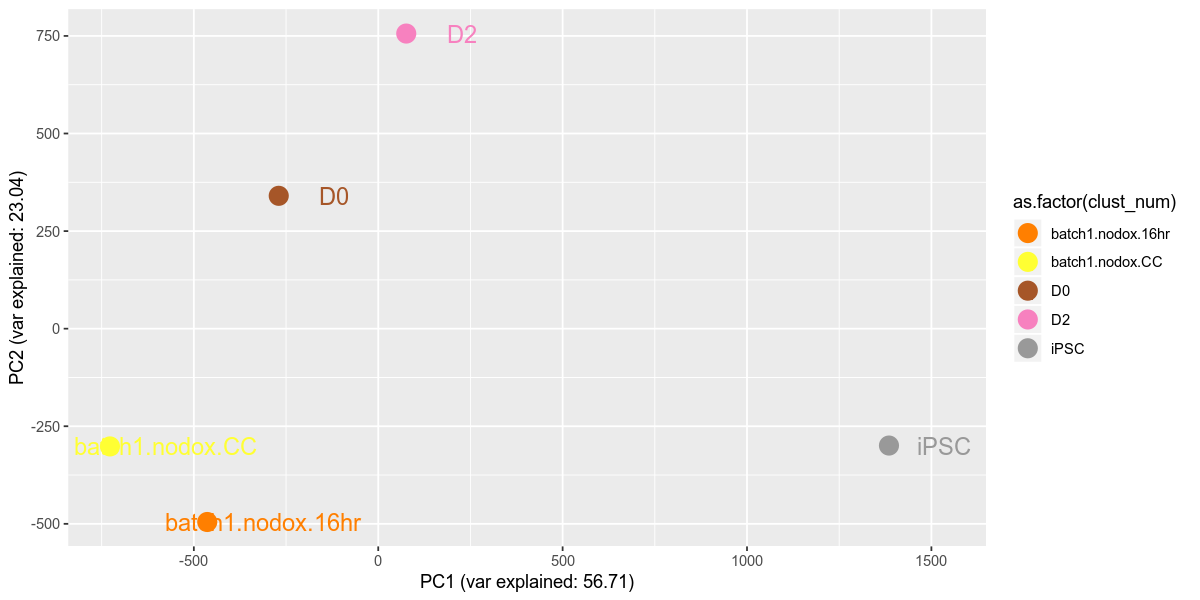

In [21]:
options(repr.plot.width = 10, repr.plot.height = 5)

ggplot(data=pcs,aes(x=PC1,y=PC2,color=as.factor(clust_num),label=ID))+
geom_point(size=5)+
scale_colour_manual(values = col_vector[seq(50,67)]) +
geom_text(size=5, nudge_x=150)+
labs(x=sprintf("PC1 (var explained: %.2f)", var_explained[1]), y = sprintf("PC2 (var explained: %.2f)", var_explained[2]))

## Clustering

In [22]:
library(ClusterR)
library(viridis)
library(scales)

Loading required package: gtools

Loading required package: viridisLite


Attaching package: ‘scales’


The following object is masked from ‘package:viridis’:

    viridis_pal




In [23]:
quantile(qn_cts, c(.25, .5, .75))

25%      50%      75% 
3.027407 4.450802 5.953874

In [24]:
sum(qn_cts[,"D0"]<3.5 & qn_cts[,"batch1.nodox.CC"]<3.5)

[1] 122301

In [35]:
cts_to_cluster = qn_cts #[(qn_cts[,"D0"]<3.5 & qn_cts[,"batch1.nodox.CC"]<3.5), ]
# cts_to_cluster = t(scale(t(qn_cts)))
# cts_to_cluster = log_norm_cts
# cts_to_cluster = cts
# cts_to_cluster = t(scale(t(log_norm_cts)))

In [36]:
dim(cts_to_cluster)

[1] 520883      5

In [54]:
# ADD RAND SEED - not required
CLUSTER_SUBSET = c("D0", "batch1.nodox.CC", "D2", "batch1.nodox.16hr") # use to cluster based on a subset of cells
km_mb = MiniBatchKmeans(cts_to_cluster[,CLUSTER_SUBSET], 
                        batch_size = 2000,
                        clusters=15,
                        num_init = 50, 
                        verbose = FALSE)

In [55]:
# reorder based on hierarchical clustering
pr_mb = predict_MBatchKMeans(cts_to_cluster[,CLUSTER_SUBSET], km_mb$centroids)

distance    = dist(t(scale(t(km_mb$centroids))))
cluster     = hclust(distance, method="ward")
dendrogram  = as.dendrogram(cluster)
rowInd = rev(order.dendrogram(dendrogram))
pr_mb = order(rowInd)[pr_mb]

The "ward" method has been renamed to "ward.D"; note new "ward.D2"



In [56]:
# no hierarchical clustering, follow order of km_mb$centroids
# pr_mb = predict_MBatchKMeans(cts_to_cluster, km_mb$centroids)

In [57]:
table(pr_mb)

pr_mb
    1     2     3     4     5     6     7     8     9    10    11    12    13 
34335 30583 29627 34803 51208 22881 32350 26117 35716 40567 37854 42631 33960 
   14    15 
39007 29244 

In [58]:
order(rowVars(km_mb$centroids))

[1]  3  2  4 14 10  6  9 11 13  1  8  7 15  5 12

In [59]:
DISPLAY_ORDER = c("D0", "batch1.nodox.CC", "D2", "batch1.nodox.16hr", "iPSC")
# DISPLAY_ORDER = c("D0", "batch2.dn.CC", "D2", "batch2.dn.16hr", "iPSC")
cts_clustered = cts_to_cluster[order(pr_mb), DISPLAY_ORDER]
head(cts_clustered, 2)

,D0,batch1.nodox.CC,D2,batch1.nodox.16hr,iPSC
chr1 1074193 1074393,4.886025,3.980393,7.382182,4.491986,5.422011
chr1 1173688 1174001,5.072544,4.204384,5.287781,5.910567,7.046180


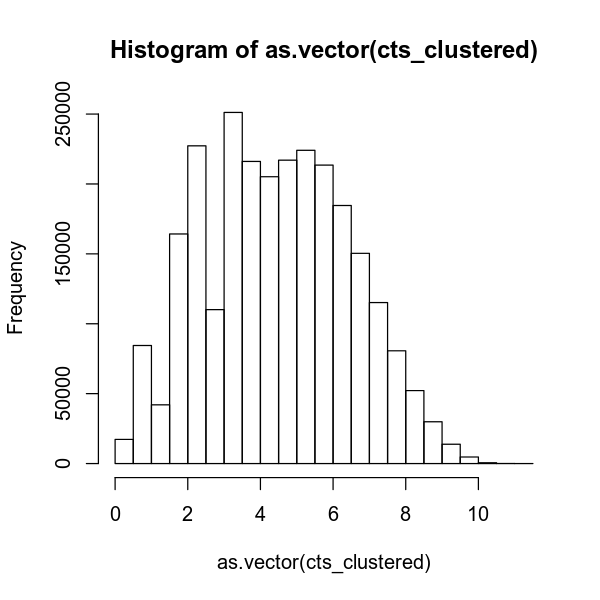

In [60]:
options(repr.plot.width = 5, repr.plot.height = 5)
hist(as.vector(cts_clustered))

Saving 6.67 x 6.67 in image



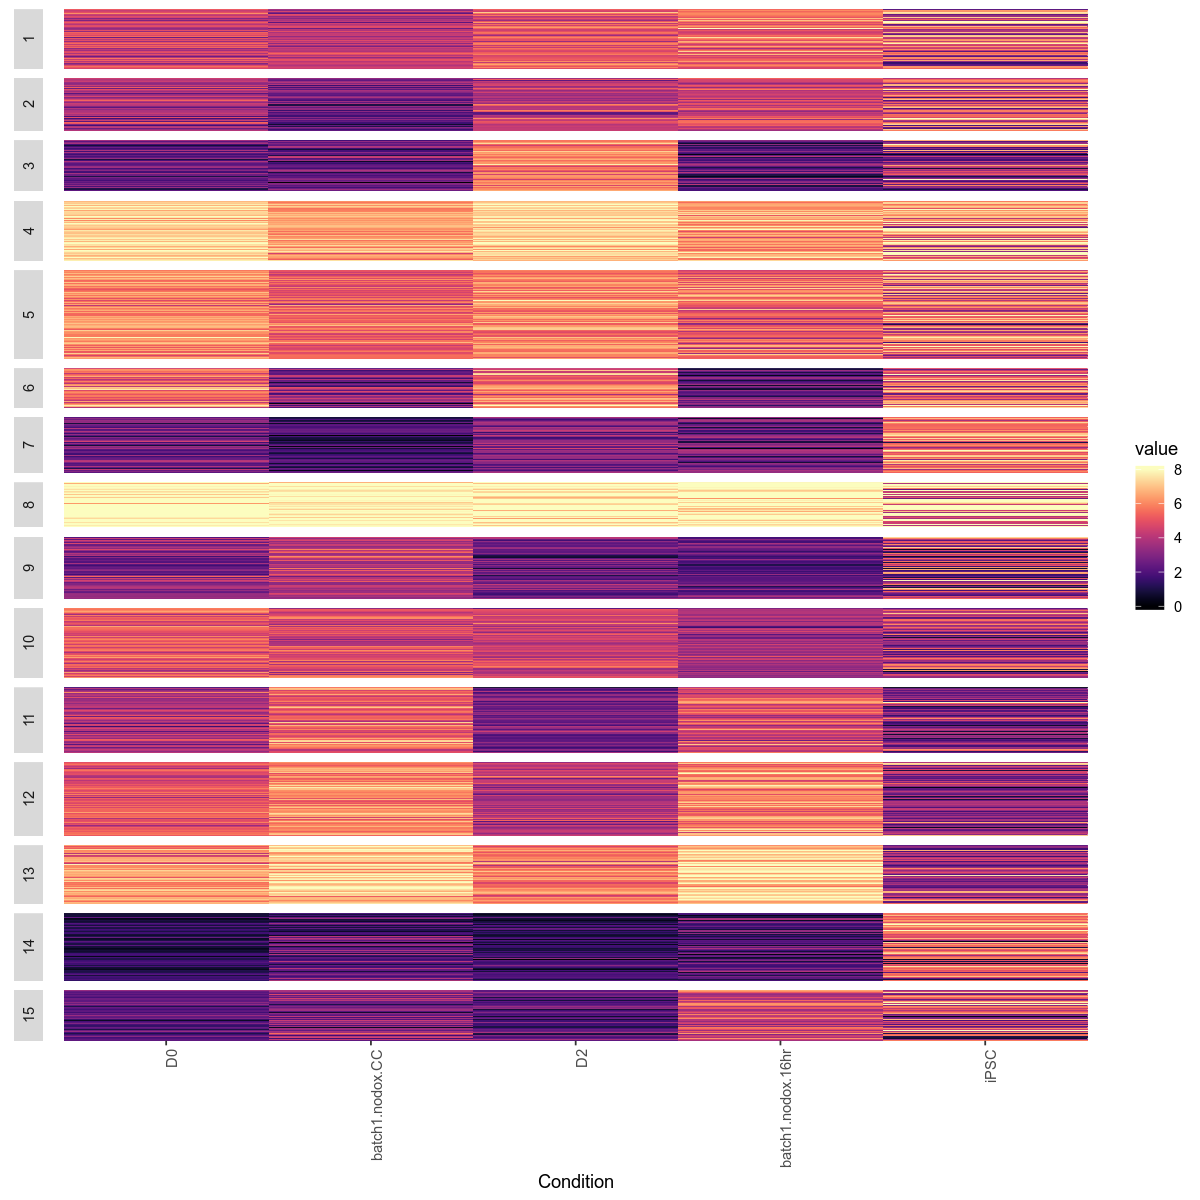

In [61]:
options(repr.plot.width = 10, repr.plot.height = 10)

idxs = seq(1, nrow(cts_clustered), 5) # if subsample
ggplot(data = melt(cts_clustered[idxs, ]), 
       mapping = aes(x = Var2,
                     y = Var1,
                     fill = value)) +
geom_tile()  + ylab(NULL) + xlab("Condition") +  
geom_raster(aes(fill=value)) +
scale_fill_viridis(limits=c(0, 8), oob=squish, option = "A") +
# scale_fill_viridis(option="A") + 
# scale_fill_gradient2(low="red", mid="black", high="blue") +
facet_grid(sort(pr_mb)[idxs] ~ ., switch = "y", scales = "free_y", space = "free_y") +
# theme_classic() +
theme(axis.text.x=element_text(angle=90,hjust=1),
      axis.text.y=element_blank(),
      axis.ticks.y=element_blank()) 
#       panel.spacing.y = unit(0.03, "cm"),
#       strip.text.y = element_text(size = 3))  
#       strip.background = element_rect(size = 0.1))

ggsave(sprintf("figs/%s_heatmap_peakwidthnorm_qn_batch1_D0_CC_D2_16hr_sorted_n%d.jpeg", format(Sys.Date(), format='%Y%m%d'), length(table(pr_mb))),
       dpi=1000)

## Writing BED files for some clusters

In [62]:
CLUSTER_IDX = 1
NORM = 'heatmap_peakwidthnorm_qn_batch1_D0_CC_D2_16hr_sorted'
BED_PATH = sprintf("beds/%s_%s_n%d/idx%d.bed", format(Sys.Date(), format='%Y%m%d'), NORM, length(table(pr_mb)), CLUSTER_IDX)
# rownames(vsd_assay_to_cluster_normalized)[(which(pr_mb==CLUSTER_IDX))]
BED_PATH

[1] "beds/20200409_heatmap_peakwidthnorm_qn_batch1_D0_CC_D2_16hr_sorted_n15/idx1.bed"

In [63]:
for (i in seq(1,length(table(pr_mb)))){
BED_PATH = sprintf("beds/%s_%s_n%d/idx%d.bed", format(Sys.Date(), format='%Y%m%d'), NORM, length(table(pr_mb)), i)
fileConn = file(BED_PATH)
writeLines(rownames(cts_to_cluster)[(which(pr_mb==i))], fileConn)
close(fileConn)}

In [64]:
ALL_PEAKS_BED_PATH = sprintf("beds/%s_%s_n%d/all_peaks.bed", format(Sys.Date(), format='%Y%m%d'), NORM, length(table(pr_mb)))
print(ALL_PEAKS_BED_PATH)
fileConn = file(ALL_PEAKS_BED_PATH)
writeLines(rownames(cts_to_cluster), fileConn)
close(fileConn)

[1] "beds/20200409_heatmap_peakwidthnorm_qn_batch1_D0_CC_D2_16hr_sorted_n15/all_peaks.bed"
